In [1]:
%matplotlib inline

# Logger
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pickle
from copy import deepcopy

# Import local paths
import sys, os
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../../openai-envs'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs import Perception
from lcs.metrics import population_metrics
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList

# Load environments
import gym
import gym_grid

In [2]:
# Papermill notebook params
env = 'grid-20-v0'
trials = 500
decay = True

# Grid

Actions:

    MOVE_LEFT = 0
    MOVE_RIGHT = 1
    MOVE_UP = 2
    MOVE_DOWN = 3


In [3]:
def avg_fitness(pop):
    return np.mean([cl.fitness for cl in pop if cl.is_reliable() and cl.does_anticipate_change()])

# collect more metrics
def grid_metrics(pop, env):
    metrics = {}
    metrics['avg_fitness'] = avg_fitness(pop)
    metrics.update(population_metrics(pop, env))
    
    return metrics

In [4]:
cfg = Configuration(
        classifier_length=2,
        number_of_possible_actions=4,
        epsilon=1.0,
        beta=0.01,
        gamma=0.95,
        theta_i=0.05,
        theta_as=10,
        theta_exp=50,
        theta_ga=50,
        do_ga=True,
        mu=0.04,
        u_max=2,
        metrics_trial_frequency=25,
        user_metrics_collector_fcn=grid_metrics) # grid_metrics

In [5]:
def print_cl(cl):
    action = None
    if cl.action == 0:
        action = '⬅'
    if cl.action == 1:
        action = '➡'
    if cl.action == 2:
        action = '⬆'
    if cl.action == 3:
        action = '⬇'
    print(f"{cl.condition} - {action} - {cl.effect} [fit: {cl.fitness:.3f}, r: {cl.r:.2f}, ir: {cl.ir:.2f}], exp: {cl.exp}")

In [6]:
def print_simple_stats(population, metrics):
    pop_size = len(population)
    
    # avg step in trial
    steps = []
    for m in metrics:
        steps.append(m['steps_in_trial'])

    print(f"Population of {pop_size}, avg steps {sum(steps)/len(steps)}, all steps {sum(steps)}")     

In [7]:
def plot_population(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    trials = [m['trial'] for m in metrics]
    
    population_size = [m['population'] for m in metrics]
    reliable_size = [m['reliable'] for m in metrics]
    
    ax.plot(trials, population_size, 'b', label='macro')
    ax.plot(trials, reliable_size, 'r', label='reliable')
    
    ax.set_title("Population size")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Number of macroclassifiers")
    ax.legend(loc='best')

In [8]:
def plot_avg_fitness(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    trials = [m['trial'] for m in metrics]
    
    avg_fitness = [m['avg_fitness'] for m in metrics]
    
    ax.plot(trials, avg_fitness, 'b')
    
    ax.set_title("Average fitness")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Fitness value")

## Grid

### Experiments

In [9]:
print(f'Running {trials} trials on [{env}], decay={decay}')

Running 500 trials on [grid-20-v0], decay=True


In [10]:
grid = gym.make(env)

In [11]:
%%time
agent = ACS2(cfg)
population, metrics = agent.explore(grid, trials, decay=decay)

/Users/khozzy/miniconda/envs/pyalcs/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/khozzy/miniconda/envs/pyalcs/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1106, 'reward': 1000, 'avg_fitness': nan, 'population': 111, 'numerosity': 453, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 50, 'steps_in_trial': 1500, 'reward': 1000, 'avg_fitness': 24.8276052663769, 'population': 80, 'numerosity': 800, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 1835, 'reward': 1000, 'avg_fitness': 55.80475742335597, 'population': 80, 'numerosity': 800, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 150, 'steps_in_trial': 2000, 'reward': 0, 'avg_fitness': 75.28799031029881, 'population': 80, 'numerosity': 800, 'reliable': 80}
INFO:lcs.agents.Agent:

CPU times: user 4min 11s, sys: 2.91 s, total: 4min 14s
Wall time: 4min 33s


In [12]:
print_simple_stats(population, metrics)

Population of 80, avg steps 1326.35, all steps 26527


In [13]:
for cl in sorted(population, key=lambda cl: -cl.fitness):
    if cl.does_anticipate_change():
        print_cl(cl)

19# - ➡ - 20# [fit: 29.901, r: 29.90, ir: 10.29], exp: 31143
20# - ⬅ - 19# [fit: 20.097, r: 20.10, ir: 0.00], exp: 30853
18# - ➡ - 19# [fit: 19.292, r: 19.29, ir: 0.00], exp: 12935
18# - ⬅ - 17# [fit: 19.152, r: 19.15, ir: 0.00], exp: 7910
17# - ⬅ - 16# [fit: 19.110, r: 19.11, ir: 0.00], exp: 6415
17# - ➡ - 18# [fit: 19.107, r: 19.11, ir: 0.00], exp: 8176
16# - ⬅ - 15# [fit: 19.070, r: 19.07, ir: 0.00], exp: 5824
16# - ➡ - 17# [fit: 19.066, r: 19.07, ir: 0.00], exp: 6659
19# - ⬅ - 18# [fit: 19.066, r: 19.07, ir: 0.00], exp: 12652
15# - ⬅ - 14# [fit: 19.037, r: 19.04, ir: 0.00], exp: 5537
15# - ➡ - 16# [fit: 19.034, r: 19.03, ir: 0.00], exp: 6058
14# - ➡ - 15# [fit: 19.002, r: 19.00, ir: 0.00], exp: 5754
14# - ⬅ - 13# [fit: 19.002, r: 19.00, ir: 0.00], exp: 5456
13# - ⬅ - 12# [fit: 18.970, r: 18.97, ir: 0.00], exp: 5546
13# - ➡ - 14# [fit: 18.969, r: 18.97, ir: 0.00], exp: 5653
#17 - ⬇ - #16 [fit: 18.947, r: 18.95, ir: 0.00], exp: 6499
#17 - ⬆ - #18 [fit: 18.944, r: 18.94, ir: 0.00], ex

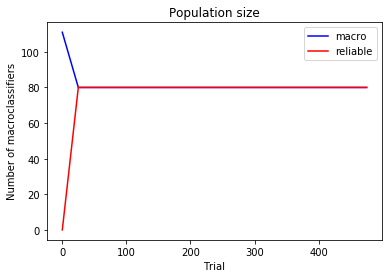

In [14]:
plot_population(metrics)

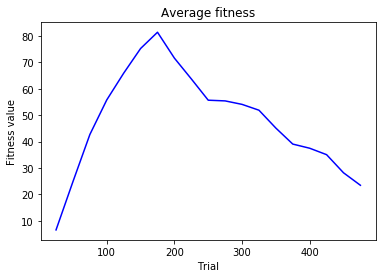

In [15]:
plot_avg_fitness(metrics)

### Pure exploitation

In [16]:
%%time
agent = ACS2(cfg, deepcopy(population))
pop_exploit, metric_exploit = agent.exploit(grid, 500)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 2000, 'reward': 0, 'avg_fitness': 18.73533476257729, 'population': 80, 'numerosity': 800, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 50, 'steps_in_trial': 2000, 'reward': 0, 'avg_fitness': 13.108029387607463, 'population': 80, 'numerosity': 800, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 262, 'reward': 1000, 'avg_fitness': 8.881001395591843, 'population': 80, 'numerosity': 800, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 150, 'steps_in_trial': 39, 'reward': 1000, 'avg_fitness': 6.279262660016175, 'population': 80, 'numerosity': 800, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 200, 'steps_in_trial': 2000, 'reward': 0, 'avg_fitness': 4.047733940506754, 'population': 80, 'numerosity': 800, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 250, 'steps_in_trial': 2000, 'reward': 0, 'avg_fitness': 2.8384301039450928, 'population': 80, 'numerosity': 800, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 

CPU times: user 2min 54s, sys: 1.7 s, total: 2min 56s
Wall time: 3min 8s


In [27]:
print_simple_stats(pop_exploit, metric_exploit)

Population of 80, avg steps 1502.9, all steps 30058


In [18]:
for cl in sorted(pop_exploit, key=lambda cl: -cl.fitness):
    if cl.does_anticipate_change():
            print_cl(cl)

#18 - ⬆ - #19 [fit: 2.527, r: 2.53, ir: 0.00], exp: 7919
#19 - ⬆ - #20 [fit: 2.289, r: 2.29, ir: 0.00], exp: 20686
#20 - ⬇ - #19 [fit: 2.267, r: 2.27, ir: 0.00], exp: 20395
#17 - ⬆ - #18 [fit: 1.084, r: 1.08, ir: 0.00], exp: 6692
#18 - ⬇ - #17 [fit: 0.985, r: 0.99, ir: 0.00], exp: 6428
#19 - ⬇ - #18 [fit: 0.985, r: 0.98, ir: 0.00], exp: 7632
#17 - ⬇ - #16 [fit: 0.983, r: 0.98, ir: 0.00], exp: 6499
#16 - ⬆ - #17 [fit: 0.980, r: 0.98, ir: 0.00], exp: 6740
#16 - ⬇ - #15 [fit: 0.979, r: 0.98, ir: 0.00], exp: 6766
#15 - ⬇ - #14 [fit: 0.973, r: 0.97, ir: 0.00], exp: 6898
#15 - ⬆ - #16 [fit: 0.973, r: 0.97, ir: 0.00], exp: 6985
#14 - ⬇ - #13 [fit: 0.968, r: 0.97, ir: 0.00], exp: 6935
#14 - ⬆ - #15 [fit: 0.968, r: 0.97, ir: 0.00], exp: 7099
#13 - ⬇ - #12 [fit: 0.964, r: 0.96, ir: 0.00], exp: 7146
#13 - ⬆ - #14 [fit: 0.964, r: 0.96, ir: 0.00], exp: 7124
#12 - ⬆ - #13 [fit: 0.961, r: 0.96, ir: 0.00], exp: 7325
#12 - ⬇ - #11 [fit: 0.961, r: 0.96, ir: 0.00], exp: 7339
#11 - ⬇ - #10 [fit: 0.958, r:

### Manual tests

In [19]:
state = Perception(("4","1"))

match = pop_exploit.form_match_set(state)
for cl in sorted(match, key=lambda cl: -cl.fitness):
        if cl.does_anticipate_change():
            print_cl(cl)
#         else:
#             print_cl(cl)

#1 - ⬆ - #2 [fit: 0.947, r: 0.95, ir: 0.00], exp: 8091
4# - ⬅ - 3# [fit: 0.946, r: 0.95, ir: 0.00], exp: 6970
4# - ➡ - 5# [fit: 0.946, r: 0.95, ir: 0.00], exp: 6519


In [20]:
import random

def find_best_moves(population, state):
    def best_fitness(match_set, action):
        action_set = [cl for cl in match_set.form_action_set(action) if cl.does_anticipate_change()]
        random.shuffle(action_set)  # in case there are many actions available
        if len(action_set):
            best_cl = max(action_set, key=lambda cl: cl.fitness)
            return best_cl.fitness
        else:
            return 0  # if classifier predicts no change it's fitness is set to 0
    
    matching = population.form_match_set(state)
    
    return {
        "left": best_fitness(matching, 0),
        "right": best_fitness(matching, 1),
        "up": best_fitness(matching, 2),
        "down": best_fitness(matching, 3)
        
    }

find_best_moves(population, Perception(("1", "1")))

{'left': 0, 'right': 18.686031398731803, 'up': 18.781515001961978, 'down': 0}

In [21]:
dim = 20
step = 1. / dim

states = []

for x in range(0, dim):
    for y in range(0, dim):
        states.append({
            "pos": (x * step, y * step),
            "cord": (x+1, y+1),
            "best": find_best_moves(population, Perception((str(x+1), str(y+1))))
        })

# show first one
states[:1]

[{'pos': (0.0, 0.0),
  'cord': (1, 1),
  'best': {'left': 0,
   'right': 18.686031398731803,
   'up': 18.781515001961978,
   'down': 0}}]

In [22]:
from itertools import chain

fitness_values = list()
for s in states:
    for v in s['best'].values():
        if v is not None:
            fitness_values.append(v)

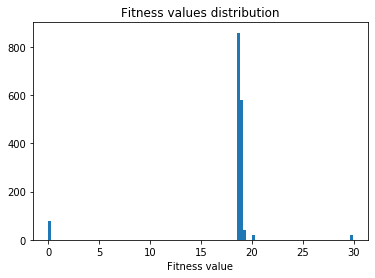

In [23]:
plt.hist(fitness_values, bins=100)
plt.title('Fitness values distribution')
plt.xlabel('Fitness value')
plt.show()

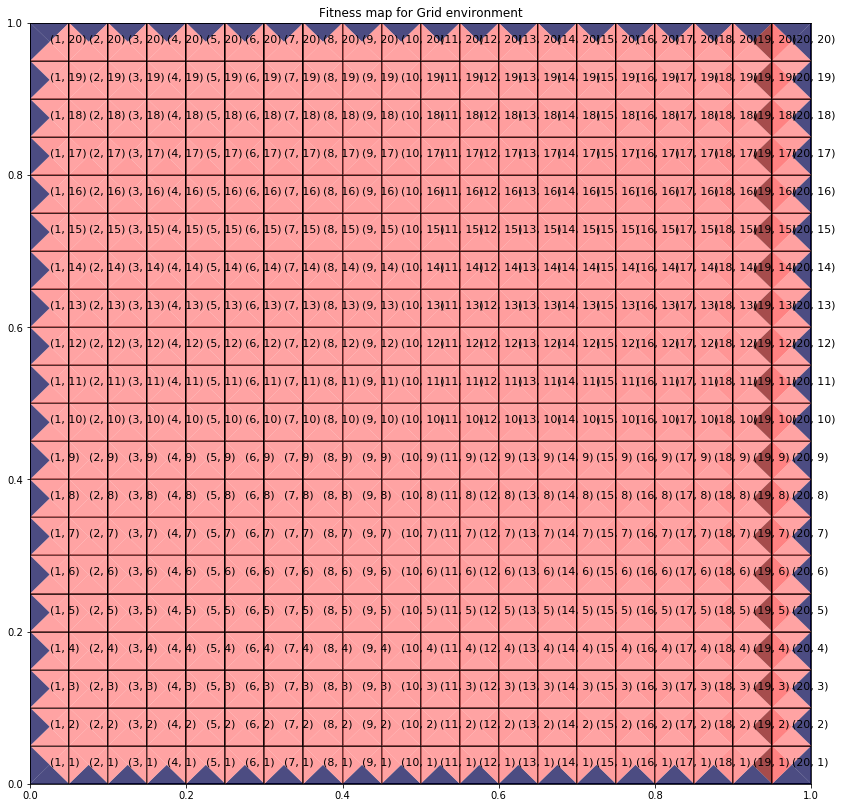

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cmx


cm = plt.get_cmap('seismic')
cNorm  = colors.Normalize(vmin=min(fitness_values), vmax=max(fitness_values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots(1, figsize=(14,14))

ax.set_title('Fitness map for Grid environment')
for state in states:
    (pos_x, pos_y) = state['pos']
    rect = patches.Rectangle((pos_x, pos_y), .2, .2, linewidth=2, edgecolor='black', facecolor='none', alpha=.7)
    
    alpha_triangles = 0.7
    
    down = plt.Polygon([(pos_x, pos_y), (pos_x+step, pos_y), (pos_x+step/2, pos_y+step/2)],
                       color=scalarMap.to_rgba(state['best']['down']),
                       alpha=alpha_triangles,linewidth=0)
    up = plt.Polygon([(pos_x, pos_y+step), (pos_x+step, pos_y+step), (pos_x+step/2, pos_y+step/2)],
                     color=scalarMap.to_rgba(state['best']['up']),
                     alpha=alpha_triangles, linewidth=0)
    left = plt.Polygon([(pos_x, pos_y), (pos_x, pos_y+step), (pos_x+step/2, pos_y+step/2)],
                     color=scalarMap.to_rgba(state['best']['left']),
                     alpha=alpha_triangles, linewidth=0)
    right = plt.Polygon([(pos_x+step, pos_y), (pos_x+step, pos_y+step), (pos_x+step/2, pos_y+step/2)],
                     color=scalarMap.to_rgba(state['best']['right']),
                     alpha=alpha_triangles, linewidth=0)
    
    plt.text(pos_x+step/2, pos_y+step/2, state['cord'], fontsize=11)  # cords
    
#     plt.text(pos_x+.07, pos_y+0.008,
#              round(state['best']['down'], 5),
#              fontsize=8)
#     plt.text(pos_x+.07, pos_y+0.18,
#              round(state['best']['up'], 5),
#              fontsize=8)
#     plt.text(pos_x+0.008, pos_y+0.07,
#              round(state['best']['left'], 5),
#              fontsize=8,
#              rotation=90)
#     plt.text(pos_x+0.17, pos_y+0.07,
#              round(state['best']['right'], 5),
#              fontsize=8,
#              rotation=-90)
    
    ax.add_patch(rect)
    ax.add_patch(down)
    ax.add_patch(up)
    ax.add_patch(left)
    ax.add_patch(right)

plt.show()

Save population and metrics

In [25]:
filename = f'{env}_{trials}_trials_decay_{decay}.pickle'
with open(filename, 'wb') as f:
    pickle.dump((population, metrics), f)